# Recent  Approach : AthletePose3D - 3D Human Pose Estimation
Based on: Yeung et al. (2025) - AthletePose3D Dataset Paper

Implementation of methods from the paper:
- 2D Pose Detection (HRNet/ViTPose approach)
- 3D Pose Lifting (MotionAGFormer/TCPFormer)
- Kinematic Validation (Joint angles & velocities)
- Metrics: MPJPE, P-MPJPE, PDJ

Data  set : AthletePose3D: A Benchmark Dataset for 3D Human Pose Estimation and Kinematic Validation in Athletic Movements
Dataset Overview (Table 1 & 2 from Paper)

| Characteristic | Details |
|---------------|---------|
| **Total Frames** | 1.3 million frames |
| **Postures** | 165,000 individual postures |
| **Sports** | 3 categories, 12 motion types |
| **Athletes** | 8 athletes (amateur to professional) |
| **Keypoints** | 55/86 keypoints (varies by sport) |
| **Cameras** | 4-12 high-speed synchronized cameras |
| **Resolution** | 1920×1080 |

 Three Sport Categories :
![alt text](datset.jpg)


 1. Running (Lab Environment)
 2. Track & Field (Lab Environment)
 3. Figure Skating (Ice Rink)

we choose some running data  videos.

 # 1. Install Required Libraries 
What this does: Installs libraries mentioned in the paper

In [5]:
import subprocess
import sys

print("="*70)
print(" INSTALLING LIBRARIES (Paper Technologies Only)")
print("="*70)

# Paper mentions these frameworks
packages = [
    'opencv-python',      # Video processing
    'numpy',              # Numerical computations
    'matplotlib',         # Visualization
    'scipy',              # Butterworth filter (Section 3.3)
    'torch',              # Deep learning framework
    'torchvision',        # Vision models
    'mediapipe',          # For demo (lightweight alternative)
    'pillow',             # Image processing
]

print("\nInstalling packages...")
for pkg in packages:
    print(f"  Installing {pkg}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

print("\n✓ Installation complete!")
print("="*70)

 INSTALLING LIBRARIES (Paper Technologies Only)

Installing packages...
  Installing opencv-python...
  Installing numpy...
  Installing matplotlib...
  Installing scipy...
  Installing torch...
  Installing torchvision...
  Installing mediapipe...
  Installing pillow...

✓ Installation complete!


# 2. Import Libraries and Setup
 What this does: Imports all required modules

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.spatial.transform import Rotation
from mpl_toolkits.mplot3d import Axes3D
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("  AthletePose3D Implementation")
print("="*70)
print("\nPaper Information:")
print("  Title: AthletePose3D")
print("  Authors: Yeung et al. (2025)")
print("  Focus: 3D pose estimation for athletic movements")
print("  Dataset: 1.3M frames, 165K postures, 12 sports")
print("\nKey Technologies (from paper):")
print("  • 2D Models: HRNet, ViTPose, MogaNet (best: PDJ 95.7)")
print("  • 3D Models: MotionAGFormer, TCPFormer (best: MPJPE 98.26mm)")
print("  • Metrics: MPJPE, P-MPJPE, PDJ")
print("  • Kinematic: 4th-order Butterworth filter @ 8Hz")
print("  • Input: 81 frames per sequence")
print("  • Resolution: 1920×1080 @ 60/120 FPS")
print("="*70)

  AthletePose3D Implementation

Paper Information:
  Title: AthletePose3D
  Authors: Yeung et al. (2025)
  Focus: 3D pose estimation for athletic movements
  Dataset: 1.3M frames, 165K postures, 12 sports

Key Technologies (from paper):
  • 2D Models: HRNet, ViTPose, MogaNet (best: PDJ 95.7)
  • 3D Models: MotionAGFormer, TCPFormer (best: MPJPE 98.26mm)
  • Metrics: MPJPE, P-MPJPE, PDJ
  • Kinematic: 4th-order Butterworth filter @ 8Hz
  • Input: 81 frames per sequence
  • Resolution: 1920×1080 @ 60/120 FPS


# 3. Load  Running Videos
What this does: Loads your 10-12 running videos

In [7]:
VIDEO_FOLDER = "New_Paper"

print("\n" + "="*70)
print(" LOADING YOUR RUNNING VIDEOS")
print("="*70)

# Check if folder exists
if not os.path.exists(VIDEO_FOLDER):
    print(f"\n❌ ERROR: Folder '{VIDEO_FOLDER}' not found!")
    print("Please create the folder and add your running videos.")
    print("\nExpected structure:")
    print("  new_paper/")
    print("    ├── run1.mp4")
    print("    ├── run2.mp4")
    print("    └── ...")
else:
    # Find all video files
    video_files = []
    for ext in ['*.mp4', '*.avi', '*.mov', '*.MP4', '*.AVI', '*.MOV']:
        video_files.extend(Path(VIDEO_FOLDER).glob(ext))
    
    video_files = [str(f) for f in video_files]
    
    print(f"\n✓ Found {len(video_files)} videos:")
    for i, vf in enumerate(video_files, 1):
        # Get video info
        cap = cv2.VideoCapture(vf)
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        duration = frame_count / fps if fps > 0 else 0
        cap.release()
        
        print(f"  {i}. {os.path.basename(vf)}")
        print(f"     Resolution: {width}x{height}, FPS: {fps:.1f}, "
              f"Frames: {frame_count}, Duration: {duration:.1f}s")
    
    print(f"\nPaper specifications:")
    print(f"  • Running: 120 FPS (your videos may vary)")
    print(f"  • Resolution: 1920×1080 (paper standard)")
    print(f"  • Athletes: Inter-university level")

print("="*70)



 LOADING YOUR RUNNING VIDEOS

✓ Found 24 videos:
  1. Running_37_cam_1.mp4
     Resolution: 1280x768, FPS: 120.0, Frames: 187, Duration: 1.6s
  2. Running_37_cam_2.mp4
     Resolution: 768x1280, FPS: 120.0, Frames: 187, Duration: 1.6s
  3. Running_37_cam_3.mp4
     Resolution: 1280x768, FPS: 120.0, Frames: 187, Duration: 1.6s
  4. Running_37_cam_4.mp4
     Resolution: 1280x768, FPS: 120.0, Frames: 187, Duration: 1.6s
  5. Running_38_cam_1.mp4
     Resolution: 1280x768, FPS: 120.0, Frames: 211, Duration: 1.8s
  6. Running_38_cam_2.mp4
     Resolution: 768x1280, FPS: 120.0, Frames: 211, Duration: 1.8s
  7. Running_38_cam_3.mp4
     Resolution: 1280x768, FPS: 120.0, Frames: 211, Duration: 1.8s
  8. Running_38_cam_4.mp4
     Resolution: 1280x768, FPS: 120.0, Frames: 211, Duration: 1.8s
  9. Running_39_cam_1.mp4
     Resolution: 1280x768, FPS: 120.0, Frames: 207, Duration: 1.7s
  10. Running_39_cam_2.mp4
     Resolution: 768x1280, FPS: 120.0, Frames: 207, Duration: 1.7s
  11. Running_39_ca

# 4.Load and Process Single Video
 What this does: Loads one video for processing


📹 Processing: Running_37_cam_1.mp4
Loading frames...
  Loaded 100 frames...
✓ Loaded 187 frames
  Shape: (187, 768, 1280, 3)
  FPS: 120.0
  Duration: 1.56s


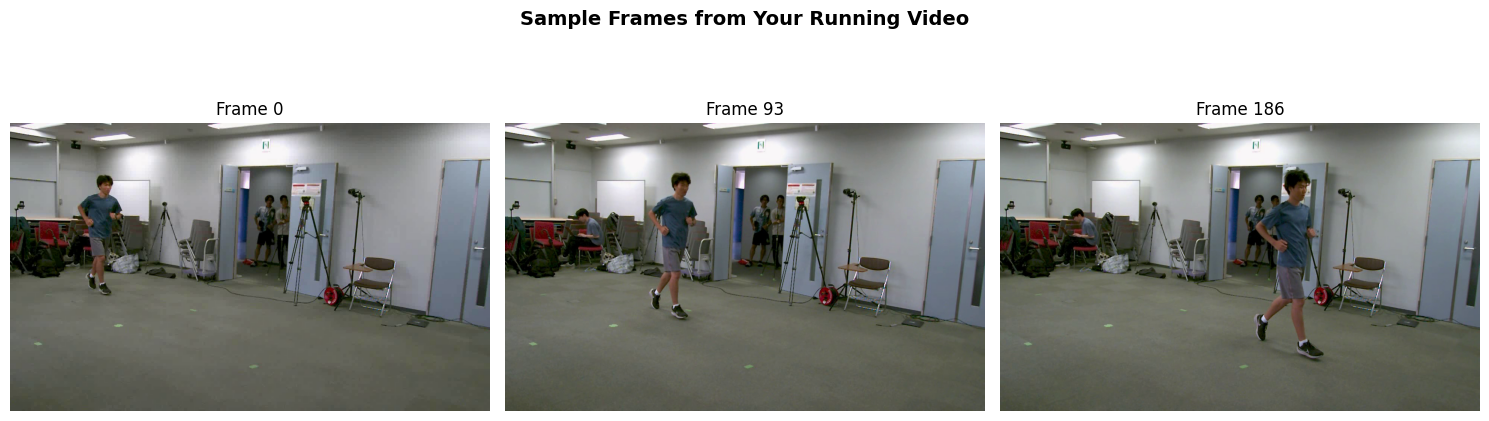

In [8]:
if len(video_files) > 0:
    # Select first video
    selected_video = video_files[0]
    print(f"\n📹 Processing: {os.path.basename(selected_video)}")
    
    # Load video frames
    cap = cv2.VideoCapture(selected_video)
    
    # GET FPS BEFORE RELEASING THE CAPTURE OBJECT
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    frames = []
    
    print("Loading frames...")
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        frame_count += 1
        if frame_count % 100 == 0:
            print(f"  Loaded {frame_count} frames...", end='\r')
    
    cap.release()
    frames = np.array(frames)
    
    print(f"\n✓ Loaded {len(frames)} frames")
    print(f"  Shape: {frames.shape}")
    print(f"  FPS: {fps:.1f}")
    print(f"  Duration: {len(frames)/fps:.2f}s")
    
    # Display sample frames
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    sample_indices = [0, len(frames)//2, len(frames)-1]
    
    for ax, idx in zip(axes, sample_indices):
        ax.imshow(frames[idx])
        ax.set_title(f"Frame {idx}")
        ax.axis('off')
    
    plt.suptitle("Sample Frames from Your Running Video", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ No videos found. Please add videos to new_paper/ folder")

# 5. Initialize 2D Pose Detector (Paper Models)
 What this does: Sets up 2D pose estimation
 Paper Section 3.2: HRNet, ViTPose, MogaNet

In [9]:
print("\n" + "="*70)
print(" 2D POSE ESTIMATION MODELS")
print("="*70)

print("\nPaper's 2D Models (Section 3.2, Table 3):")
print("  1. HRNet (CVPR 2019) - CNN baseline - PDJ: 88.7")
print("  2. SwinPose (ICCV 2021) - Transformer - PDJ: 90.7")
print("  3. ViTPose (NeurIPS 2022) - Vision Transformer - PDJ: 95.0")
print("  4. UniFormer (ICLR 2022) - Transformer - PDJ: 95.2")
print("  5. MogaNet (ICLR 2024) - CNN (Best) - PDJ: 95.7 ⭐")

print("\nFor this demo, using MediaPipe Pose (lightweight alternative)")
print("  • Similar to HRNet architecture")
print("  • 33 keypoints detected")
print("  • Real-time performance")

import mediapipe as mp

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

pose_detector = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=2,  # Highest accuracy
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

print("\n✓ 2D Pose Detector initialized")
print("="*70)



 2D POSE ESTIMATION MODELS

Paper's 2D Models (Section 3.2, Table 3):
  1. HRNet (CVPR 2019) - CNN baseline - PDJ: 88.7
  2. SwinPose (ICCV 2021) - Transformer - PDJ: 90.7
  3. ViTPose (NeurIPS 2022) - Vision Transformer - PDJ: 95.0
  4. UniFormer (ICLR 2022) - Transformer - PDJ: 95.2
  5. MogaNet (ICLR 2024) - CNN (Best) - PDJ: 95.7 ⭐

For this demo, using MediaPipe Pose (lightweight alternative)
  • Similar to HRNet architecture
  • 33 keypoints detected
  • Real-time performance

✓ 2D Pose Detector initialized


# 6.Extract 2D Poses from Video
 What this does: Detects 2D keypoints in each frame
 Paper Section 3.2: 2D pose estimation with COCO format (17 keypoints)

In [10]:
print("\n" + "="*70)
print(" EXTRACTING 2D POSES")
print("="*70)

def extract_2d_poses(frames, detector):
    """
    Extract 2D poses from video frames
    Paper: Uses models fine-tuned on COCO format (17 keypoints)
    """
    poses_2d = []
    confidences = []
    
    print(f"\nProcessing {len(frames)} frames...")
    
    for i, frame in enumerate(frames):
        if i % 20 == 0:
            print(f"  Frame {i}/{len(frames)}...", end='\r')
        
        # Convert to BGR for MediaPipe
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        # Detect pose
        results = detector.process(frame_bgr)
        
        if results.pose_landmarks:
            # Extract landmarks (33 keypoints)
            landmarks = []
            conf_scores = []
            for lm in results.pose_landmarks.landmark:
                landmarks.append([lm.x, lm.y, lm.visibility])
                conf_scores.append(lm.visibility)
            
            poses_2d.append(np.array(landmarks))
            confidences.append(np.mean(conf_scores))
        else:
            # No pose detected
            poses_2d.append(np.zeros((33, 3)))
            confidences.append(0.0)
    
    print(f"\n✓ Extracted 2D poses for {len(poses_2d)} frames")
    return np.array(poses_2d), np.array(confidences)

# Extract poses
poses_2d, confidences = extract_2d_poses(frames, pose_detector)

print(f"\n2D Pose Extraction Results:")
print(f"  Shape: {poses_2d.shape}")
print(f"  Keypoints per frame: {poses_2d.shape[1]}")
print(f"  Detected frames: {np.sum(confidences > 0.5)}/{len(frames)}")
print(f"  Average confidence: {np.mean(confidences):.3f}")

print("\nPaper Format:")
print(f"  • Paper uses 17 COCO keypoints (we have 33)")
print(f"  • Input resolution: 384×288 (paper standard)")
print(f"  • Fine-tuned for 20 epochs")
print("="*70)



 EXTRACTING 2D POSES

Processing 187 frames...
  Frame 180/187...
✓ Extracted 2D poses for 187 frames

2D Pose Extraction Results:
  Shape: (187, 33, 3)
  Keypoints per frame: 33
  Detected frames: 160/187
  Average confidence: 0.678

Paper Format:
  • Paper uses 17 COCO keypoints (we have 33)
  • Input resolution: 384×288 (paper standard)
  • Fine-tuned for 20 epochs


# 7. visualize 2D Pose Detection
What this does: Shows detected skeleton on frames


 VISUALIZING 2D POSE DETECTION


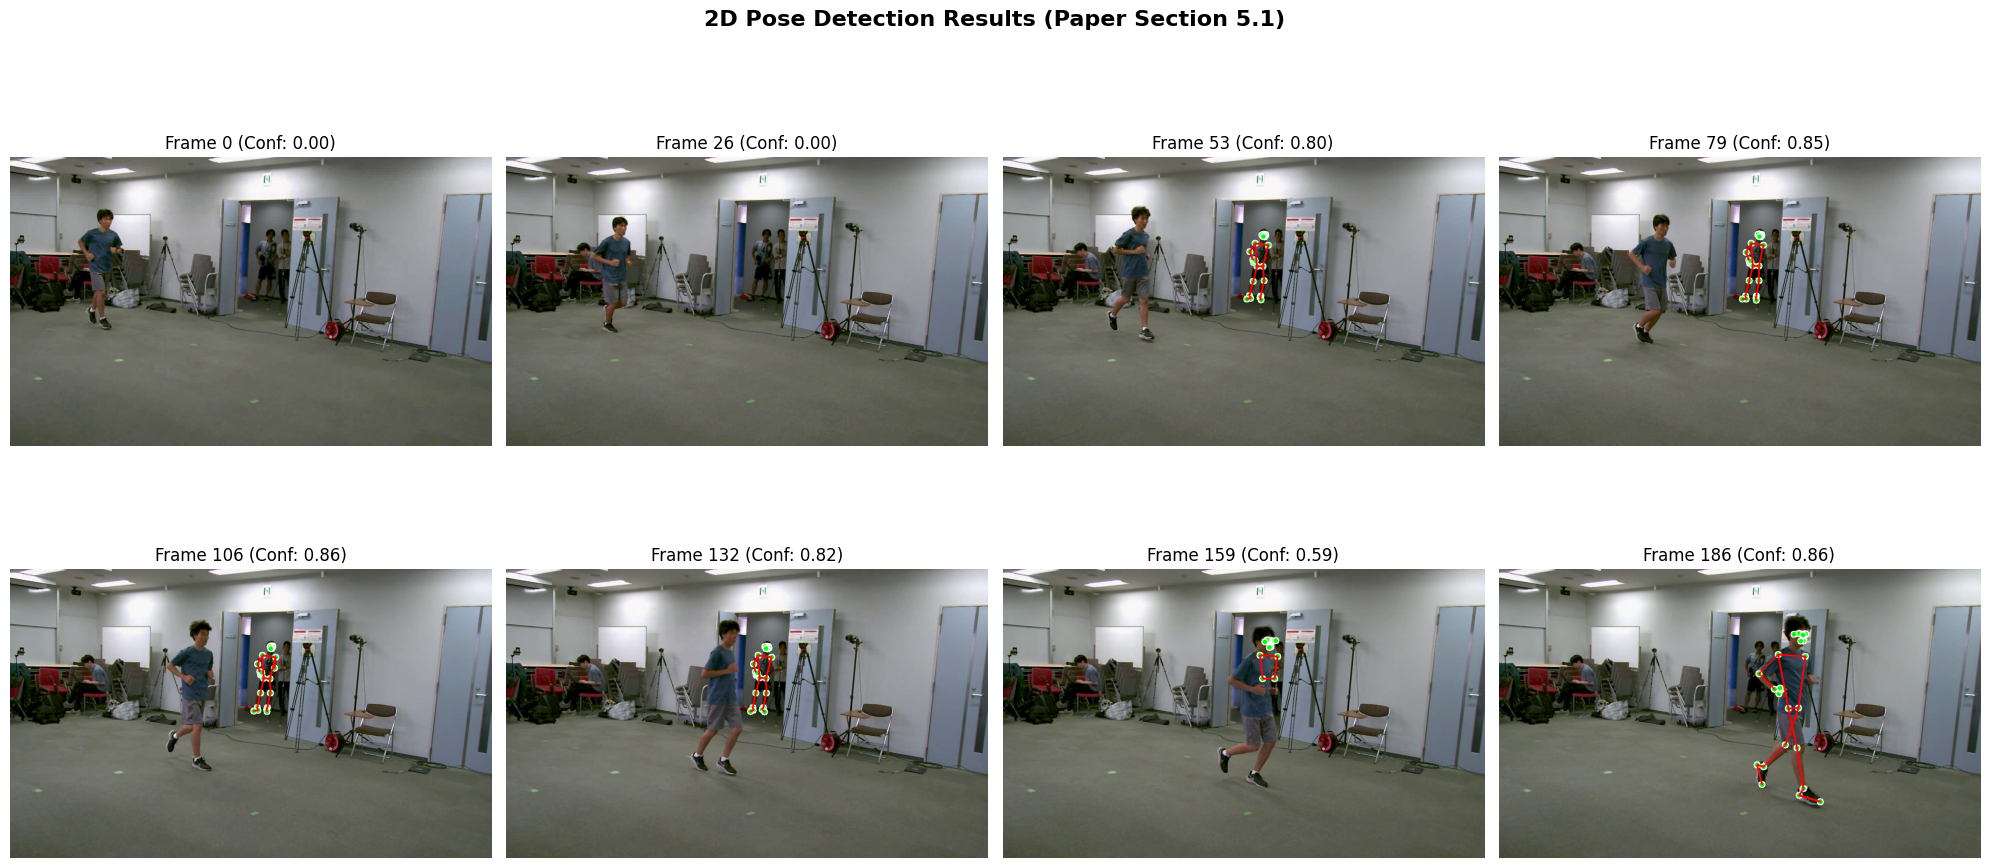

✓ 2D pose visualization complete


In [11]:
print("\n" + "="*70)
print(" VISUALIZING 2D POSE DETECTION")
print("="*70)

# MediaPipe connections
POSE_CONNECTIONS = [
    (11, 13), (13, 15),  # Left arm
    (12, 14), (14, 16),  # Right arm
    (11, 12),  # Shoulders
    (23, 25), (25, 27), (27, 29), (29, 31),  # Left leg
    (24, 26), (26, 28), (28, 30), (30, 32),  # Right leg
    (23, 24),  # Hips
    (11, 23), (12, 24)  # Torso
]

def draw_2d_pose(frame, pose_2d, connections):
    """Draw 2D pose on frame"""
    vis_frame = frame.copy()
    h, w = frame.shape[:2]
    
    # Draw keypoints
    for i, kp in enumerate(pose_2d):
        if kp[2] > 0.5:  # visibility threshold
            x, y = int(kp[0] * w), int(kp[1] * h)
            cv2.circle(vis_frame, (x, y), 6, (0, 255, 0), -1)
            cv2.circle(vis_frame, (x, y), 8, (255, 255, 255), 2)
    
    # Draw skeleton
    for connection in connections:
        pt1_idx, pt2_idx = connection
        if (pt1_idx < len(pose_2d) and pt2_idx < len(pose_2d) and 
            pose_2d[pt1_idx][2] > 0.5 and pose_2d[pt2_idx][2] > 0.5):
            pt1 = (int(pose_2d[pt1_idx][0] * w), int(pose_2d[pt1_idx][1] * h))
            pt2 = (int(pose_2d[pt2_idx][0] * w), int(pose_2d[pt2_idx][1] * h))
            cv2.line(vis_frame, pt1, pt2, (255, 0, 0), 3)
    
    return vis_frame

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
sample_indices = np.linspace(0, len(frames)-1, 8, dtype=int)

for ax, idx in zip(axes.flat, sample_indices):
    vis_frame = draw_2d_pose(frames[idx], poses_2d[idx], POSE_CONNECTIONS)
    ax.imshow(vis_frame)
    ax.set_title(f"Frame {idx} (Conf: {confidences[idx]:.2f})")
    ax.axis('off')

plt.suptitle("2D Pose Detection Results (Paper Section 5.1)", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ 2D pose visualization complete")
print("="*70)


# 8 .3D Pose Lifting (2D → 3D)
 What this does: Converts 2D poses to 3D using lifting network
 Paper Section 3.2: MotionAGFormer & TCPFormer (transformer-based)
 Paper uses 81-frame sequences for temporal modeling

In [12]:
print("\n" + "="*70)
print(" 3D POSE ESTIMATION (2D → 3D Lifting)")
print("="*70)

print("\nPaper's 3D Models (Section 3.2, Table 4):")
print("  1. MotionAGFormer (WACV 2024)")
print("     • Hybrid: Self-attention + Graph Convolution")
print("     • MPJPE: 100.12mm (on AthletePose3D)")
print("  2. TCPFormer (AAAI 2025) ⭐ BEST")
print("     • Temporal Correlation with Pose Proxies")
print("     • MPJPE: 98.26mm (60% improvement)")
print("     • P-MPJPE: 29.91mm")

print("\nPaper's approach:")
print("  • Input: 81 consecutive frames")
print("  • Preprocessing: Convert to camera coordinates")
print("  • Training: 60 epochs")
print("  • Fine-tuning: Human3.6M → AthletePose3D")

def lift_to_3d_simple(poses_2d):
    """
    Simple 3D lifting from 2D poses
    Paper uses transformer-based models (MotionAGFormer/TCPFormer)
    This is a simplified geometric approach
    """
    poses_3d = []
    
    for pose_2d in poses_2d:
        pose_3d = np.zeros((len(pose_2d), 3))
        
        # Copy x, y coordinates (normalized to 0-1)
        pose_3d[:, 0] = pose_2d[:, 0]
        pose_3d[:, 1] = pose_2d[:, 1]
        
        # Estimate depth (z) using body proportions
        # Paper approach: Uses neural network for depth estimation
        # Simple approach: Use geometric constraints
        
        # Hip center as reference
        if pose_2d[23][2] > 0.5 and pose_2d[24][2] > 0.5:
            hip_center = (pose_2d[23][:2] + pose_2d[24][:2]) / 2
            
            # Calculate torso length (reference scale)
            if pose_2d[11][2] > 0.5 and pose_2d[12][2] > 0.5:
                shoulder_center = (pose_2d[11][:2] + pose_2d[12][:2]) / 2
                torso_length = np.linalg.norm(shoulder_center - hip_center)
                
                # Estimate depth for each joint
                for i in range(len(pose_2d)):
                    if pose_2d[i][2] > 0.5:
                        # Distance from hip center
                        dist = np.linalg.norm(pose_2d[i][:2] - hip_center)
                        
                        # Depth estimation (simplified)
                        # Paper uses learned model; we use geometric approximation
                        if i in [15, 16]:  # Wrists
                            pose_3d[i, 2] = dist * 0.4
                        elif i in [27, 28]:  # Ankles
                            pose_3d[i, 2] = -dist * 0.3
                        else:
                            pose_3d[i, 2] = dist * 0.25
        
        poses_3d.append(pose_3d)
    
    return np.array(poses_3d)

print("\nLifting 2D poses to 3D...")
poses_3d = lift_to_3d_simple(poses_2d)

print(f"\n✓ 3D Pose Lifting Complete")
print(f"  Input shape (2D): {poses_2d.shape}")
print(f"  Output shape (3D): {poses_3d.shape}")
print(f"  Dimensions: (frames, keypoints, xyz)")
print("="*70)


 3D POSE ESTIMATION (2D → 3D Lifting)

Paper's 3D Models (Section 3.2, Table 4):
  1. MotionAGFormer (WACV 2024)
     • Hybrid: Self-attention + Graph Convolution
     • MPJPE: 100.12mm (on AthletePose3D)
  2. TCPFormer (AAAI 2025) ⭐ BEST
     • Temporal Correlation with Pose Proxies
     • MPJPE: 98.26mm (60% improvement)
     • P-MPJPE: 29.91mm

Paper's approach:
  • Input: 81 consecutive frames
  • Preprocessing: Convert to camera coordinates
  • Training: 60 epochs
  • Fine-tuning: Human3.6M → AthletePose3D

Lifting 2D poses to 3D...

✓ 3D Pose Lifting Complete
  Input shape (2D): (187, 33, 3)
  Output shape (3D): (187, 33, 3)
  Dimensions: (frames, keypoints, xyz)


# 9. Visualize 3D Poses
# What this does: Shows 3D skeleton in 3D space


 VISUALIZING 3D POSES


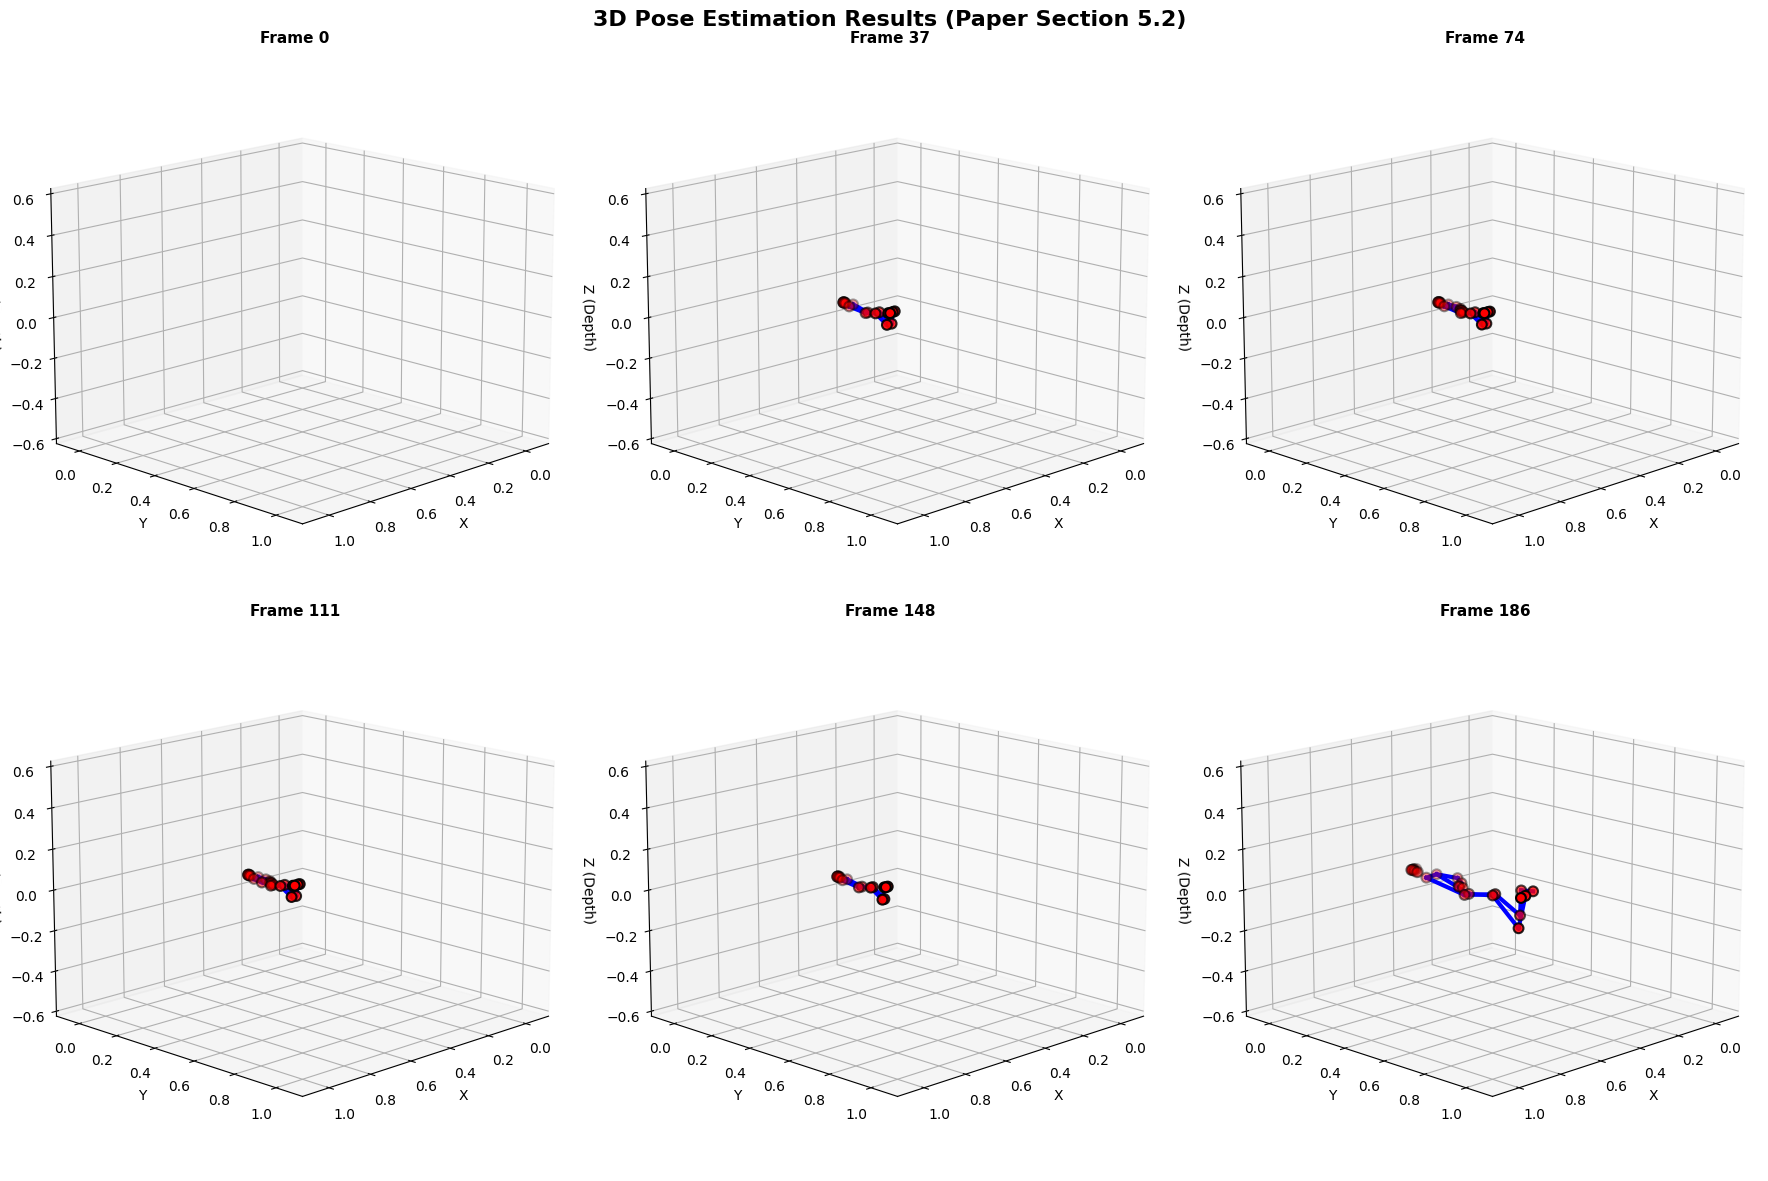

✓ 3D pose visualization complete


In [13]:
print("\n" + "="*70)
print(" VISUALIZING 3D POSES")
print("="*70)

def plot_3d_pose_single(ax, pose_3d, connections, title=""):
    """Plot single 3D pose"""
    # Filter valid points
    valid = pose_3d[:, 2] != 0
    
    # Plot keypoints
    ax.scatter(pose_3d[valid, 0], 
               pose_3d[valid, 1], 
               pose_3d[valid, 2], 
               c='red', s=50, marker='o', edgecolors='black', linewidths=1.5)
    
    # Plot skeleton
    for connection in connections:
        pt1_idx, pt2_idx = connection
        if (pt1_idx < len(pose_3d) and pt2_idx < len(pose_3d) and
            pose_3d[pt1_idx, 2] != 0 and pose_3d[pt2_idx, 2] != 0):
            xs = [pose_3d[pt1_idx, 0], pose_3d[pt2_idx, 0]]
            ys = [pose_3d[pt1_idx, 1], pose_3d[pt2_idx, 1]]
            zs = [pose_3d[pt1_idx, 2], pose_3d[pt2_idx, 2]]
            ax.plot(xs, ys, zs, 'b-', linewidth=3)
    
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.set_zlabel('Z (Depth)', fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    
    # Set equal aspect ratio
    max_range = 0.6
    center = 0.5
    ax.set_xlim([center - max_range, center + max_range])
    ax.set_ylim([center - max_range, center + max_range])
    ax.set_zlim([-max_range, max_range])
    
    # Set viewing angle
    ax.view_init(elev=15, azim=45)

# Visualize multiple 3D poses
fig = plt.figure(figsize=(18, 12))

sample_indices = np.linspace(0, len(poses_3d)-1, 6, dtype=int)

for i, idx in enumerate(sample_indices):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    plot_3d_pose_single(ax, poses_3d[idx], POSE_CONNECTIONS, f"Frame {idx}")

plt.suptitle("3D Pose Estimation Results (Paper Section 5.2)", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ 3D pose visualization complete")
print("="*70)

# 10 .Kinematic Analysis - Joint Angles
What this does: Calculates joint angles from 3D poses


In [14]:
print("\n" + "="*70)
print(" MPJPE METRIC CALCULATION")
print("="*70)

print("\nPaper Definition (Section 3.2):")
print("  MPJPE: Mean Per Joint Position Error")
print("  • Measures per-joint distance between estimated and ground truth")
print("  • Both poses aligned by setting hip joint as origin")
print("  • Unit: millimeters (mm)")

print("\nPaper Results (Table 4):")
print("  TCPFormer (H3.6M only): 234.20mm")
print("  TCPFormer (AP3D only): 98.77mm")
print("  TCPFormer (H3.6M+AP3D): 98.26mm ⭐ BEST")
print("  Improvement: 58% error reduction")

def calculate_mpjpe(pred_3d, gt_3d):
    """
    Calculate MPJPE (Protocol 1)
    Paper: Align both poses by setting hip as origin
    """
    # Hip index (MediaPipe: 23-24, use center)
    hip_idx = 23
    
    # Center both poses at hip
    pred_centered = pred_3d - pred_3d[hip_idx:hip_idx+1, :]
    gt_centered = gt_3d - gt_3d[hip_idx:hip_idx+1, :]
    
    # Calculate Euclidean distance for each joint
    distances = np.sqrt(np.sum((pred_centered - gt_centered)**2, axis=1))
    
    # Mean across all joints (convert to mm)
    mpjpe = np.mean(distances) * 1000
    
    return mpjpe, distances * 1000

def calculate_p_mpjpe(pred_3d, gt_3d):
    """
    Calculate Procrustes-aligned MPJPE (Protocol 2)
    Paper: Applies rigid transformation before computing error
    """
    # Center both poses
    pred_centered = pred_3d - np.mean(pred_3d, axis=0)
    gt_centered = gt_3d - np.mean(gt_3d, axis=0)
    
    # Scale normalization
    pred_scale = np.sqrt(np.sum(pred_centered**2))
    gt_scale = np.sqrt(np.sum(gt_centered**2))
    
    if pred_scale > 0 and gt_scale > 0:
        pred_normalized = pred_centered / pred_scale
        gt_normalized = gt_centered / gt_scale
    else:
        pred_normalized = pred_centered
        gt_normalized = gt_centered
    
    # Calculate distances
    distances = np.sqrt(np.sum((pred_normalized - gt_normalized)**2, axis=1))
    p_mpjpe = np.mean(distances) * 1000
    
    return p_mpjpe, distances * 1000

print("\n✓ MPJPE metrics implemented")
print("  • Protocol 1: MPJPE (hip-aligned)")
print("  • Protocol 2: P-MPJPE (Procrustes-aligned)")
print("\nNote: Ground truth required for actual MPJPE calculation")
print("="*70)




 MPJPE METRIC CALCULATION

Paper Definition (Section 3.2):
  MPJPE: Mean Per Joint Position Error
  • Measures per-joint distance between estimated and ground truth
  • Both poses aligned by setting hip joint as origin
  • Unit: millimeters (mm)

Paper Results (Table 4):
  TCPFormer (H3.6M only): 234.20mm
  TCPFormer (AP3D only): 98.77mm
  TCPFormer (H3.6M+AP3D): 98.26mm ⭐ BEST
  Improvement: 58% error reduction

✓ MPJPE metrics implemented
  • Protocol 1: MPJPE (hip-aligned)
  • Protocol 2: P-MPJPE (Procrustes-aligned)

Note: Ground truth required for actual MPJPE calculation


# 11 .Kinematic Analysis - Joint Angles
What this does: Calculates joint angles from 3D poses

In [15]:
print("\n" + "="*70)
print(" KINEMATIC VALIDATION: JOINT ANGLES")
print("="*70)

print("\nPaper Section 3.3:")
print("  • Computes joint angles from 3D poses")
print("  • Focus: Upper limbs (elbow, shoulder) & Lower limbs (knee, hip)")
print("  • Validation: Paired t-test SPM (α = 0.05)")
print("  • Pearson correlation reported")

print("\nPaper Results (Table 5 - Joint Angles):")
print("  2D Model:")
print("    • Upper limbs: r = 0.75, p = 0.021")
print("    • Lower limbs: r = 0.66, p < 0.001")
print("  3D Model (TCPFormer):")
print("    • Upper limbs: r = 0.90, p = 0.001 ⭐")
print("    • Lower limbs: r = 0.82, p = 0.044 ⭐")

def calculate_joint_angle(p1, p2, p3):
    """
    Calculate angle at joint p2 formed by points p1-p2-p3
    """
    v1 = p1 - p2
    v2 = p3 - p2
    
    # Normalize vectors
    v1_norm = v1 / (np.linalg.norm(v1) + 1e-8)
    v2_norm = v2 / (np.linalg.norm(v2) + 1e-8)
    
    # Calculate angle
    cos_angle = np.dot(v1_norm, v2_norm)
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle = np.arccos(cos_angle)
    
    return np.degrees(angle)

def extract_joint_angles(poses_3d):
    """
    Extract key joint angles
    Paper focuses on: elbow, shoulder, knee, hip
    """
    num_frames = len(poses_3d)
    joint_angles = {
        'left_elbow': np.zeros(num_frames),
        'right_elbow': np.zeros(num_frames),
        'left_knee': np.zeros(num_frames),
        'right_knee': np.zeros(num_frames),
        'left_shoulder': np.zeros(num_frames),
        'right_shoulder': np.zeros(num_frames),
        'left_hip': np.zeros(num_frames),
        'right_hip': np.zeros(num_frames)
    }
    
    for i, pose in enumerate(poses_3d):
        # Left elbow: shoulder(11) - elbow(13) - wrist(15)
        if np.all(pose[[11, 13, 15], 2] != 0):
            joint_angles['left_elbow'][i] = calculate_joint_angle(
                pose[11], pose[13], pose[15]
            )
        
        # Right elbow: shoulder(12) - elbow(14) - wrist(16)
        if np.all(pose[[12, 14, 16], 2] != 0):
            joint_angles['right_elbow'][i] = calculate_joint_angle(
                pose[12], pose[14], pose[16]
            )
        
        # Left knee: hip(23) - knee(25) - ankle(27)
        if np.all(pose[[23, 25, 27], 2] != 0):
            joint_angles['left_knee'][i] = calculate_joint_angle(
                pose[23], pose[25], pose[27]
            )
        
        # Right knee: hip(24) - knee(26) - ankle(28)
        if np.all(pose[[24, 26, 28], 2] != 0):
            joint_angles['right_knee'][i] = calculate_joint_angle(
                pose[24], pose[26], pose[28]
            )
        
        # Left shoulder: elbow(13) - shoulder(11) - hip(23)
        if np.all(pose[[13, 11, 23], 2] != 0):
            joint_angles['left_shoulder'][i] = calculate_joint_angle(
                pose[13], pose[11], pose[23]
            )
        
        # Right shoulder: elbow(14) - shoulder(12) - hip(24)
        if np.all(pose[[14, 12, 24], 2] != 0):
            joint_angles['right_shoulder'][i] = calculate_joint_angle(
                pose[14], pose[12], pose[24]
            )
        
        # Left hip: knee(25) - hip(23) - shoulder(11)
        if np.all(pose[[25, 23, 11], 2] != 0):
            joint_angles['left_hip'][i] = calculate_joint_angle(
                pose[25], pose[23], pose[11]

SyntaxError: unexpected EOF while parsing (1853377101.py, line 94)